# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import time
import copy

from minot.ClusterTools import map_tools
import pitszi

# Parameters

In [2]:
output_dir = '/Users/adam/Desktop/pitszi/'

In [3]:
#----- Physical model parameters
redshift = 0.5
M500 = 1e15*u.Msun
RA, Dec   = 30*u.deg, 55*u.deg
dRA, dDec = 80*u.arcsec, -25*u.arcsec
axis_q1, axis_q2 = 0.7, 0.7
euler_1, euler_2, euler_3 = 0*u.deg, 90*u.deg, 35*u.deg

fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 800*u.kpc
fluct_seed = int(np.random.uniform(0,100000))

In [4]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM1 = 18*u.arcsec
beam_FWHM2 = 13*u.arcsec

# Transfer function
karcsec1 = np.linspace(0, 1/beam_FWHM1.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov1 = 1/(7*60)
TF1 = {'k':karcsec1, 'TF':1-np.exp(-karcsec1.to_value('arcsec-1')/kfov1)}
karcsec2 = np.linspace(0, 1/beam_FWHM2.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov2 = 1/(4*60)
TF2 = {'k':karcsec2, 'TF':1-np.exp(-karcsec2.to_value('arcsec-1')/kfov2)}

# Mask
mask_Ntheta500 = 1

# Noise
noise_k1 = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)
noise_r1 = lambda r_arcsec: (1 + np.exp((r_arcsec-200)/80))
noise_k2 = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)/1.5
noise_r2 = lambda r_arcsec: (1 + np.exp((r_arcsec-150)/60))

In [5]:
#----- Analysis parameters
# Image sampling
los_size = 2*u.Mpc
los_reso = 100*u.kpc

# Pk measurement
Nbins_pk = 30
scale_bins = 'lin'
kmin_pk = 1/(60*5)*u.arcsec**-1
kmax_pk = 1/(beam_FWHM1.to('arcsec'))

# weight definition
method_w8_radial  = True
method_w8_smooth  = 20*u.arcsec
method_w8_beam    = True
method_w8_TF      = False

# methodology
method_data_deconv = False
method_use_covmat  = False
method_parallel    = False

# MCMC
nwalkers = 20
nsteps = 500
burnin = 200
mcmc_reset = True
mcmc_run = True
mcmc_Nresamp = 100

# Generate mock data

In [6]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA+dRA, Dec=Dec+dDec, redshift=redshift, M500=M500, silent=True, output_dir=output_dir)
mock.set_pressure_profile_universal_param('A10MD')
mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'statistics':'gaussian',
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}
mock.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                    'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}

mock.map_center = SkyCoord(RA, Dec, frame="icrs")
mock.map_fov    = [6, 4]*u.arcmin
mock.map_reso  = 5*u.arcsec
mock.los_reso  = los_reso
mock.los_size  = los_size
mock.R_truncation = mock.R500*10

mock.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 73 , 49 , 21
   Pixel size :      31.4     kpc ;     5.0      arcsec
   Fov size :  [   2295.2   ,   1540.6   ] kpc ; [   6.083    ,   4.083    ] arcmin
   L.o.S. resolution :        100.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (30., 55.)>
   k min/max projected :       0.002740  /  0.098630   1/arcsec
   k min/max projected :       0.000436  /  0.015685   1/kpc
   k min/max L.o.S. (eq.) :    0.002994  /  0.029944   1/arcsec
   k min/max L.o.S. :          0.000476  /  0.004762   1/kpc
   k max Nyquist :             0.029944   1/arcsec
   k max Nyquist :             0.004762   1/kpc


In [7]:
#===== Define the mask
ramap, decmap = map_tools.get_radec_map(mock.get_map_header())
dist_map = map_tools.greatcircle(ramap, decmap, (RA+dRA).to_value('deg'), (Dec+dDec).to_value('deg'))
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 

In [8]:
#===== Initiate a data object and fake data
#----- Init with the mock
data1 = pitszi.Data(mock.get_sz_map(), mock.get_map_header(), 
                    psf_fwhm=beam_FWHM1,transfer_function=TF1, noise_model=[noise_r1, noise_k1], mask=mask,
                    output_dir=output_dir, silent=True)
data2 = pitszi.Data(mock.get_sz_map(), mock.get_map_header(), 
                    psf_fwhm=beam_FWHM2,transfer_function=TF2, noise_model=[noise_r2, noise_k2], mask=mask,
                    output_dir=output_dir, silent=True)

#----- Define the noise properties
data1.noise_mc = data1.get_noise_monte_carlo_from_model(Nmc=1000, center=mock.map_center)
data1.noise_rms = data1.get_noise_rms_from_model(Nmc=1000, center=mock.map_center)

data2.noise_mc = data2.get_noise_monte_carlo_from_model(Nmc=1000, center=mock.map_center)
data2.noise_rms = data2.get_noise_rms_from_model(Nmc=1000, center=mock.map_center)

#----- Mock the data
img1 = data1.set_image_to_mock(mock, model_seed=fluct_seed, model_no_fluctuations=False, 
                               noise_origin='model', noise_center=mock.map_center)
img2 = data2.set_image_to_mock(mock, model_seed=fluct_seed, model_no_fluctuations=False, 
                               noise_origin='model', noise_center=mock.map_center)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in reciprocal
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in reciprocal
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in reciprocal
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in reciprocal
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in reciprocal
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in reciprocal
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykerne

In [9]:
def simu_cib(Nsource=300):
    sfov = mock.get_map_fov().to_value('deg')
    RA0  = mock.get_map_header()['CRVAL1']
    Dec0 = mock.get_map_header()['CRVAL2']
    src1 = np.zeros(img1.shape)
    src2 = np.zeros(img2.shape)
    for i in range(Nsource):
        dRA = np.random.uniform(-1,1)*sfov[0]/2/np.cos(Dec0*np.pi/180)
        dDec = np.random.uniform(-1,1)*sfov[1]/2
        dist_map = map_tools.greatcircle(ramap, decmap, RA0+dRA, Dec0+dDec)
        flux = np.random.lognormal(0,1)/10
        if flux < 0.5:
            src1 += -flux*np.exp(-dist_map**2/2/(beam_FWHM1.to_value('deg')/2.35)**2) * 1e-3/12
            src2 += -flux*np.exp(-dist_map**2/2/(beam_FWHM2.to_value('deg')/2.35)**2) * 1e-3/12
    return src1, src2

0 / 1000
50 / 1000
100 / 1000
150 / 1000
200 / 1000
250 / 1000
300 / 1000
350 / 1000
400 / 1000
450 / 1000
500 / 1000
550 / 1000
600 / 1000
650 / 1000
700 / 1000
750 / 1000
800 / 1000
850 / 1000
900 / 1000
950 / 1000


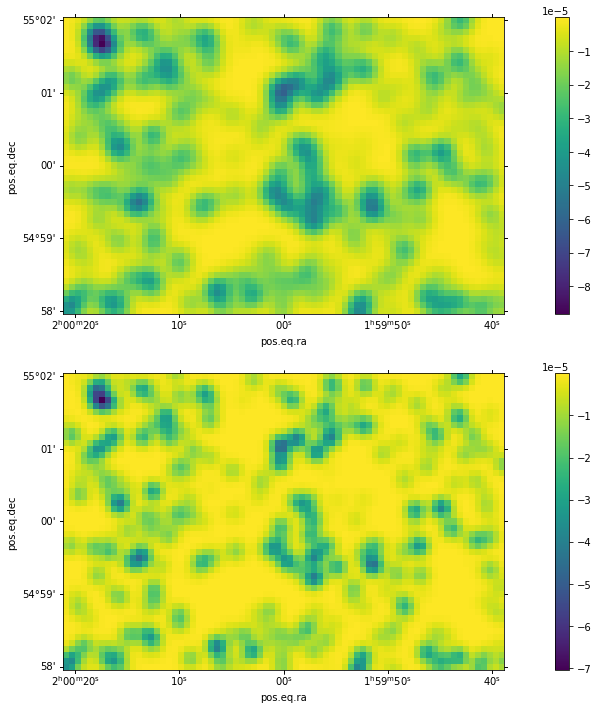

In [10]:
#===== Add CIB to data
cib1, cib2 = simu_cib()  

plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(18, 12))
ax = plt.subplot(2, 1, 1, projection=WCS(mock.get_map_header()))
plt.imshow(cib1)
plt.colorbar()
ax = plt.subplot(2, 1, 2, projection=WCS(mock.get_map_header()))
plt.imshow(cib2)
plt.colorbar()

data1.image += cib1
data2.image += cib2

#===== CIB simulation
Ncib = 1000
cib1_mc = np.zeros((Ncib, cib1.shape[0], cib1.shape[1]))
cib2_mc = np.zeros((Ncib, cib2.shape[0], cib2.shape[1]))
for imc in range(Ncib):
    if imc % 50 == 0: print(imc, '/', Ncib)
    cib1_imc, cib2_imc = simu_cib()
    cib1_mc[imc,:,:] = cib1_imc
    cib2_mc[imc,:,:] = cib2_imc

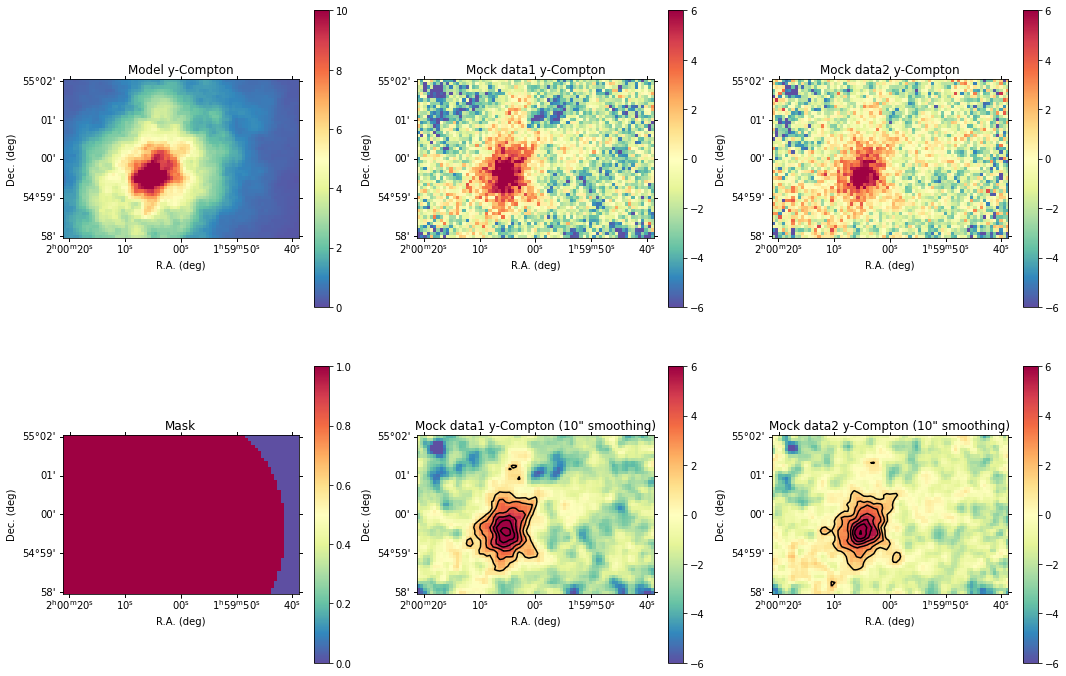

In [11]:
visu_smooth = 10

#===== Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(18, 12))

ax = plt.subplot(2, 3, 1, projection=WCS(mock.get_map_header()))
plt.imshow(mock.get_sz_map(seed=fluct_seed, no_fluctuations=False)*1e5, cmap='Spectral_r', vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 2, projection=WCS(data1.header))
plt.imshow(data1.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data1 y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 3, projection=WCS(data2.header))
plt.imshow(data2.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data2 y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 4, projection=WCS(data1.header))
plt.imshow(data1.mask, cmap='Spectral_r', vmin=0, vmax=1)
cb = plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 5, projection=WCS(data1.header))
plt.imshow(gaussian_filter(data1.image, sigma=visu_smooth/2.35/data1.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data1.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data1.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data1.image, sigma=visu_smooth/2.35/data1.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data1 y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 6, projection=WCS(data2.header))
plt.imshow(gaussian_filter(data2.image, sigma=visu_smooth/2.35/data2.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data2.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data2.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data2.image, sigma=visu_smooth/2.35/data2.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data2 y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

In [12]:
model = copy.deepcopy(mock)

# Pk constraints

In [13]:
method_use_covmat = True

In [14]:
#===== Define the ROI
Rroi = 1.5 # arcmin
ramap, decmap = map_tools.get_radec_map(mock.get_map_header())
dist_map = map_tools.greatcircle(ramap, decmap, (RA+dRA).to_value('deg'), (Dec+dDec).to_value('deg'))
roi = dist_map * 0 + 1
roi[dist_map > Rroi/60] = 0 

### Single spectra

In [15]:
FlucInf1 = pitszi.InferenceFluctuation(data1, model, 
                                       nuisance_bkg_mc1=cib1_mc,
                                       method_use_covmat=method_use_covmat, method_parallel=method_parallel, method_data_deconv=method_data_deconv,
                                       kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                       mcmc_nwalkers=nwalkers,mcmc_nsteps=nsteps,mcmc_burnin=burnin,
                                       mcmc_reset=mcmc_reset,mcmc_run=mcmc_run,
                                       mcmc_Nresamp=mcmc_Nresamp,
                                       output_dir=output_dir, silent=False)

FlucInf1.set_method_w8(roi_mask=roi,
                       apply_radial_model=method_w8_radial, 
                       conv_radial_model_beam=method_w8_beam, conv_radial_model_TF=method_w8_TF, 
                       remove_GNFW_core=True, smooth_FWHM=method_w8_smooth)

FlucInf1.pk_setup()

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                 Fluctuation Inference                      
------------------------------------------------------------
----- Checking the inputs -----
      - Data1, data2, and model projection OK.
----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [ 6.  2.  8. 12. 10. 16.  8. 24. 12. 20. 22. 16. 32. 26. 22. 34. 32. 36.
 26. 42. 38. 44. 36. 44. 50. 40. 56. 38. 62. 54.]
      - Minimal count in k bins: 2.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing


In [16]:
unit = 'kpc'
if unit == 'arcsec':
    phys=False
if unit == 'kpc':
    phys=True
    
k2d, pk2d_data = FlucInf1.get_pk2d_data(physical=phys)
k2d, pk2d_noise, pk2d_noisecovmat = FlucInf1.get_pk2d_noise_statistics(physical=phys)
k2d, pk2d_modref, pk2d_modcovmat = FlucInf1.get_pk2d_model_statistics(physical=phys, Nmc=100)
k2d, pk2d_bkg, pk2d_bkgcovmat = FlucInf1.get_pk2d_bkg_statistics(physical=phys)

k2d, pk2d_test_modbrute  = FlucInf1.get_pk2d_model_brute(physical=phys)
k2d, pk2d_test_moddeproj = FlucInf1.get_pk2d_model_proj(physical=phys)

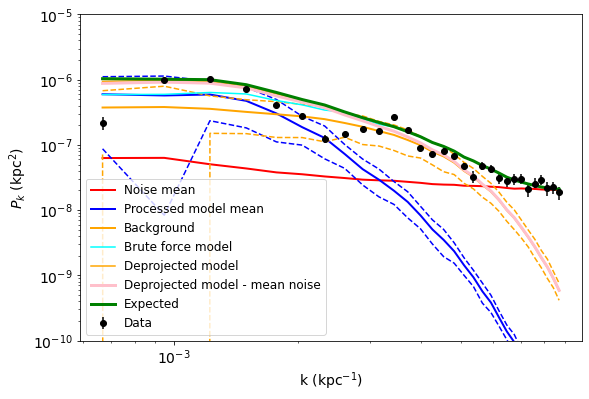

In [17]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(0, figsize=(9, 6))

plt.errorbar(k2d.to_value(unit+'-1'), pk2d_data.to_value(unit+'2'), 
             np.diag(pk2d_noisecovmat.to_value(unit+'4'))**0.5, marker='o', ls='', color='k', label='Data')
plt.plot(k2d.to_value(unit+'-1'), pk2d_noise.to_value(unit+'2'), color='red', lw=2, label='Noise mean')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2'), color='blue', lw=2, label='Processed model mean')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2') + np.diag(pk2d_modcovmat.to_value(unit+'4'))**0.5, color='blue', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2') - np.diag(pk2d_modcovmat.to_value(unit+'4'))**0.5, color='blue', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_bkg.to_value(unit+'2'), color='orange', lw=2, label='Background')
plt.plot(k2d.to_value(unit+'-1'), pk2d_bkg.to_value(unit+'2') + np.diag(pk2d_bkgcovmat.to_value(unit+'4'))**0.5, color='orange', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_bkg.to_value(unit+'2') - np.diag(pk2d_bkgcovmat.to_value(unit+'4'))**0.5, color='orange', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_modbrute.to_value(unit+'2'), color='cyan', label='Brute force model')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_moddeproj.to_value(unit+'2'), color='orange', label='Deprojected model')
plt.plot(k2d.to_value(unit+'-1'), (pk2d_test_moddeproj-pk2d_noise).to_value(unit+'2'), color='pink', lw=3, label='Deprojected model - mean noise')
plt.plot(k2d.to_value(unit+'-1'), (pk2d_bkg+pk2d_modref+pk2d_noise).to_value(unit+'2'), color='green', lw=3, label='Expected')
plt.xscale('log')
plt.yscale('log')
plt.ylim(np.amax(pk2d_data.to_value(unit+'2'))*5e-3, np.amax(pk2d_data.to_value(unit+'2'))*1.5)
plt.ylim(1e-10,1e-5)
plt.xlabel('k ('+unit+'$^{-1}$)')
plt.ylabel(r'$P_k$ ('+unit+'$^{2}$)')
plt.legend(fontsize=12)

In [18]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],      
    'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
    'Abkg':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }

In [19]:
Pname, Popt1, Pcov1 = FlucInf1.run_curvefit_fluctuation(fitpar_pk3d, show_fit_result=True)

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
param 0 (Norm): 
   median   = 0.5391528236067951 -0.16833174402552464 +0.16760697254381962
   best-fit = 0.6363695586421885 -0.26554847906091805 +0.07039023750842621
   Norm = 0.5391528236067951_{-0.16833174402552464}^{0.16760697254381962}
param 1 (Linj): 
   median   = 696.5918019323913 -170.38553222866267 +172.55765164244258
   best-fit = 695.0420761140139 -168.83580641028527 +174.10737746081998
   Linj = 696.5918019323913_{-170.38553222866267}^{172.55765164244258}
param 2 (Anoise): 
   median   = 1.0828906304849784 -0.13032709047171742 +0.13068817678204359
   best-fit = 1.016277945467569 -0.06371440545430807 +0.19730086179945294
   Anoise = 1.0828906304849784_{-0.13032709047171742}^{0.13068817678204359}
param 3 (Abkg): 
   median   = 0.6083874725469889 -0.27490754923715 +0.2830792120939193
   best-fit = 0.4924861023792791 -0.159006179

In [21]:
Pname, samp1 = FlucInf1.run_mcmc_fluctuation(fitpar_pk3d, kind='projection', show_fit_result=True)

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/adam/Desktop/pitszi//pitszi_MCMC_Fluctuation_projection_sampler.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj' 'Anoise' 'Abkg']
      - Starting point mean:          
[5.e-01 8.e+02 1.e+00 1.e+00]
      - Starting point dispersion :   
[5.e-01 5.e+02 2.e-01 2.e-01]
      - Minimal starting point:       
[  0 100   0   0]
      - Maximal starting point:       
[   3 3000    2    2]
      - Number of dimensions:         
4
      - Parallel mode:                
False
      - Use covariance matrix?        
True
-----
----- Does the sampler already exist? -----
      - Yes, but reset the MCMC even though the sampler already exists
----- MCMC sampling -----
      - Runing 500 MCMC steps


100%|██████████| 500/500 [15:33<00:00,  1.87s/it]


param 0 (Norm): 
   median   = 0.6591225644293405 -0.11673556889564185 +0.10187654852261074
   best-fit = 0.6916521243106304 -0.14926512877693177 +0.06934698864132083
   Norm = 0.6591225644293405_{-0.11673556889564185}^{0.10187654852261074}
param 1 (Linj): 
   median   = 831.9568758590168 -82.35684508547092 +121.50254740857247
   best-fit = 811.2683320102175 -61.668301236671596 +142.1910912573718
   Linj = 831.9568758590168_{-82.35684508547092}^{121.50254740857247}
param 2 (Anoise): 
   median   = 0.8781436903643299 -0.1178161937132769 +0.12836406845016446
   best-fit = 0.9170576039760437 -0.1567301073249907 +0.08945015483845065
   Anoise = 0.8781436903643299_{-0.1178161937132769}^{0.12836406845016446}
param 3 (Abkg): 
   median   = 0.9231977103984415 -0.26764540147715477 +0.2428810946768465
   best-fit = 0.8606119238140362 -0.2050596148927495 +0.30546688126125177
   Abkg = 0.9231977103984415_{-0.26764540147715477}^{0.2428810946768465}


### Cross spectra

In [22]:
FlucInfX = pitszi.InferenceFluctuation(data1, model, data2=data2,
                                       nuisance_bkg_mc1=cib1_mc, nuisance_bkg_mc2=cib2_mc,
                                       method_use_covmat=method_use_covmat, 
                                       method_parallel=method_parallel, 
                                       method_data_deconv=method_data_deconv,
                                       kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                       mcmc_nwalkers=nwalkers,mcmc_nsteps=nsteps,mcmc_burnin=burnin,mcmc_reset=mcmc_reset,mcmc_run=mcmc_run,mcmc_Nresamp=mcmc_Nresamp,
                                       output_dir=output_dir, silent=True)

FlucInfX.set_method_w8(roi_mask=roi,
                       apply_radial_model=method_w8_radial, 
                       conv_radial_model_beam=method_w8_beam, 
                       conv_radial_model_TF=method_w8_TF, 
                       remove_GNFW_core=True, 
                       smooth_FWHM=method_w8_smooth)

FlucInfX.pk_setup()

In [23]:
unit = 'kpc'
if unit == 'arcsec':
    phys=False
if unit == 'kpc':
    phys=True
    
k2d, pk2d_data = FlucInfX.get_pk2d_data(physical=phys)
k2d, pk2d_noise, pk2d_noisecovmat = FlucInfX.get_pk2d_noise_statistics(physical=phys)
k2d, pk2d_modref, pk2d_modcovmat = FlucInfX.get_pk2d_model_statistics(physical=phys, Nmc=100)
k2d, pk2d_bkg, pk2d_bkgcovmat = FlucInfX.get_pk2d_bkg_statistics(physical=phys)

k2d, pk2d_test_modbrute  = FlucInfX.get_pk2d_model_brute(physical=phys)
k2d, pk2d_test_moddeproj = FlucInfX.get_pk2d_model_proj(physical=phys)

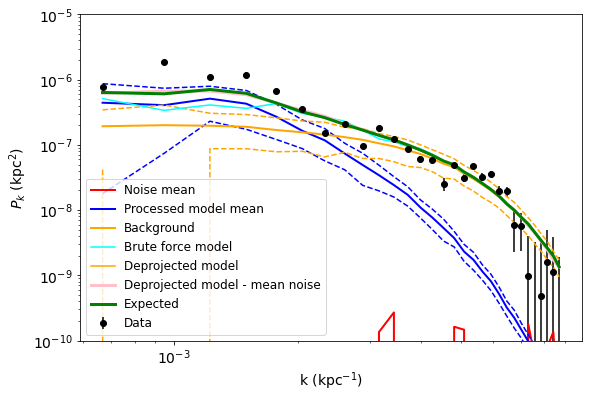

In [24]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(0, figsize=(9, 6))

plt.errorbar(k2d.to_value(unit+'-1'), pk2d_data.to_value(unit+'2'), 
             np.diag(pk2d_noisecovmat.to_value(unit+'4'))**0.5, marker='o', ls='', color='k', label='Data')
plt.plot(k2d.to_value(unit+'-1'), pk2d_noise.to_value(unit+'2'), color='red', lw=2, label='Noise mean')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2'), color='blue', lw=2, label='Processed model mean')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2') + np.diag(pk2d_modcovmat.to_value(unit+'4'))**0.5, color='blue', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2') - np.diag(pk2d_modcovmat.to_value(unit+'4'))**0.5, color='blue', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_bkg.to_value(unit+'2'), color='orange', lw=2, label='Background')
plt.plot(k2d.to_value(unit+'-1'), pk2d_bkg.to_value(unit+'2') + np.diag(pk2d_bkgcovmat.to_value(unit+'4'))**0.5, color='orange', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_bkg.to_value(unit+'2') - np.diag(pk2d_bkgcovmat.to_value(unit+'4'))**0.5, color='orange', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_modbrute.to_value(unit+'2'), color='cyan', label='Brute force model')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_moddeproj.to_value(unit+'2'), color='orange', label='Deprojected model')
plt.plot(k2d.to_value(unit+'-1'), (pk2d_test_moddeproj-pk2d_noise).to_value(unit+'2'), color='pink', lw=3, label='Deprojected model - mean noise')
plt.plot(k2d.to_value(unit+'-1'), (pk2d_bkg+pk2d_modref+pk2d_noise).to_value(unit+'2'), color='green', lw=3, label='Expected')
plt.xscale('log')
plt.yscale('log')
plt.ylim(np.amax(pk2d_data.to_value(unit+'2'))*5e-3, np.amax(pk2d_data.to_value(unit+'2'))*1.5)
plt.ylim(1e-10,1e-5)
plt.xlabel('k ('+unit+'$^{-1}$)')
plt.ylabel(r'$P_k$ ('+unit+'$^{2}$)')
plt.legend(fontsize=12)

In [25]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],      
    #'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
    'Abkg':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }

In [26]:
FlucInfX.nuisance_Anoise = 0

In [27]:
Pname, PoptX, PcovX = FlucInfX.run_curvefit_fluctuation(fitpar_pk3d, show_fit_result=True)

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
param 0 (Norm): 
   median   = 0.6809304902443821 -0.05313818313818608 +0.054748533058137205
   best-fit = 0.6968733663873206 -0.06908105928112451 +0.03880565691519877
   Norm = 0.6809304902443821_{-0.05313818313818608}^{0.054748533058137205}
param 1 (Linj): 
   median   = 839.4159285638607 -58.696650843577345 +59.932627072617265
   best-fit = 839.0768084661999 -58.357530745916506 +60.271747170278104
   Linj = 839.4159285638607_{-58.696650843577345}^{59.932627072617265}
param 2 (Abkg): 
   median   = 0.8184220448246133 -0.24325568264280084 +0.24285144525331148
   best-fit = 1.0672061802647814 -0.4920398180829689 +-0.005932690186856604
   Abkg = 0.8184220448246133_{-0.24325568264280084}^{0.24285144525331148}


/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_plot.py:869: RuntimeWarning: invalid value encountered in sqrt
  err_noise = np.sqrt(2*np.pi*k2d**2)/(2*np.sqrt(pk2d_data))*pk2d_data_err_noise
/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_plot.py:870: RuntimeWarning: invalid value encountered in sqrt
  err_nbkg  = np.sqrt(2*np.pi*k2d**2)/(2*np.sqrt(pk2d_data))*(pk2d_data_err_noise**2
/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_plot.py:872: RuntimeWarning: invalid value encountered in sqrt
  err_tot   = np.sqrt(2*np.pi*k2d**2)/(2*np.sqrt(pk2d_data))*(pk2d_data_err_model**2
/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_plot.py:880: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(k2d, np.sqrt(2*np.pi*k2d**2*pk2d_data), err_tot, marker='.', ls='', color='lightgrey',
/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_plot.py:88

In [28]:
Pname, sampX = FlucInfX.run_mcmc_fluctuation(fitpar_pk3d, kind='projection', show_fit_result=True)

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- No existing sampler found
----- Does the sampler already exist? -----
      - No, start from scratch


100%|██████████| 500/500 [16:00<00:00,  1.92s/it]


param 0 (Norm): 
   median   = 0.6777235414934175 -0.05812827091031414 +0.050520526522028764
   best-fit = 0.6810699151769208 -0.06147464459381746 +0.04717415283852544
   Norm = 0.6777235414934175_{-0.05812827091031414}^{0.050520526522028764}
param 1 (Linj): 
   median   = 838.3212886112916 -54.74040256018077 +59.02586745636245
   best-fit = 841.0573872209648 -57.47650116985392 +56.2897688466893
   Linj = 838.3212886112916_{-54.74040256018077}^{59.02586745636245}
param 2 (Abkg): 
   median   = 0.8133692130774752 -0.21983663271424458 +0.24252312070197934
   best-fit = 0.8018798852811517 -0.20834730491792108 +0.25401244849830285
   Abkg = 0.8133692130774752_{-0.21983663271424458}^{0.24252312070197934}


/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_plot.py:869: RuntimeWarning: invalid value encountered in sqrt
  err_noise = np.sqrt(2*np.pi*k2d**2)/(2*np.sqrt(pk2d_data))*pk2d_data_err_noise
/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_plot.py:870: RuntimeWarning: invalid value encountered in sqrt
  err_nbkg  = np.sqrt(2*np.pi*k2d**2)/(2*np.sqrt(pk2d_data))*(pk2d_data_err_noise**2
/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_plot.py:872: RuntimeWarning: invalid value encountered in sqrt
  err_tot   = np.sqrt(2*np.pi*k2d**2)/(2*np.sqrt(pk2d_data))*(pk2d_data_err_model**2
/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_plot.py:880: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(k2d, np.sqrt(2*np.pi*k2d**2*pk2d_data), err_tot, marker='.', ls='', color='lightgrey',
/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_plot.py:88